# Fine Food Review Classification

In this single notebook, I download a dataset from [Kaggle](https://www.kaggle.com/), prepare the data for a neural network, then train a character-based LSTM model to distinguish between 5-star and 1-star reviews. 

First I import the libraries that I need:
- PyTorch for tensors, tensor functions, and Modules
- Pandas for dataframes to hold my dataset
- random for shuffling data

In [1]:
import torch
import torch.nn as nn
from torch.functional import F
import pandas as pd
import random

## Reproducibility

I set the random seeds for Python and PyTorch so other people can get the same results:

In [2]:
torch.manual_seed(0)
random.seed(0)

The other source of randomness is when I use the `sample` method on DataFrames to shuffle them, but this random seed will be set during each method call.

## Download

I'll be using the dataset [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews). To download with the kaggle api, I had to first install the command line tool and follow the relevant instructions [here](https://www.kaggle.com/docs/api). 

In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

In [4]:
import zipfile
zipfile.ZipFile('amazon-fine-food-reviews.zip').extractall('.')

In [5]:
df = pd.read_csv('Reviews.csv')

## Data Preprocessing

I only want the review text and the scores:

In [6]:
df = df[['Text', 'Score']]

I also create a new column that shows the length of each review text:

In [7]:
df['Length'] = df['Text'].apply(len)

I remove any reviews longer than 500 characters so that training won't take too long, and because the sentiment of the review can probably be determined within the first 500 characters:

In [8]:
df = df[df['Length'] <= 500]

I want to see how many of each review score I have in the dataset:

In [9]:
df.groupby('Score').agg('count')

,Text,Length
Score,,
1,36599,36599
2,19853,19853
3,27125,27125
4,53400,53400
5,277850,277850


It looks like there are enough 1-star and 5-star reviews for me to just train with those (making this a binary classification task):

In [10]:
df_1s = df[df['Score']==1]

In [11]:
df_5s = df[df['Score']==5]

I want the data to be balanced (the same number of items in each category), which it isn't at the moment:

In [12]:
len(df_1s), len(df_5s)

(36599, 277850)

So I randomly pick a subset of the 5-star reviews that is the same size as my collection of 1-star reviews:

In [13]:
df_5s = df_5s.sample(len(df_1s), random_state=0)

And I check that they are now the same size:

In [14]:
len(df_1s), len(df_5s)

(36599, 36599)

## Review text length analysis

I want to see a histogram of the lengths of all the review texts in both of the categories:

<AxesSubplot:>

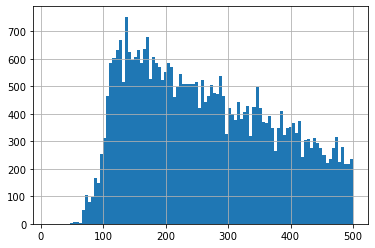

In [15]:
df_1s['Length'].hist(bins=100)

<AxesSubplot:>

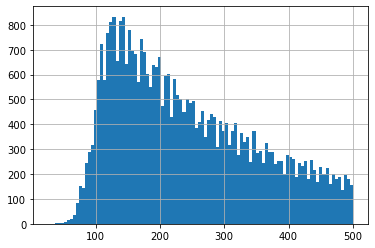

In [16]:
df_5s['Length'].hist(bins=100)

And I can also look at the average review lengths:

In [17]:
df_1s['Length'].mean(), df_5s['Length'].mean()

(264.7288723735621, 242.80302740512036)

The average actually isn't that important, though. The important takeaway is that there are many reviews of many different lengths. 

When I group reviews together in batches and pad them to be the same sequence length, I will need to consider how to batch them together in a way that doesn't cause too much unnecessary padding.

## Final dataset and splits

I create the final dataset for my project by combining the 1-star and 5-star reviews into a single DataFrame:

In [18]:
df_full = pd.concat([df_1s, df_5s])

In [19]:
len(df_full)

73198

Now I need to split the dataset into training and validation sets. I do this by taking the first 80% of the items, and create the variable `cut` to mark the split point:

In [20]:
cut = int(.8*len(df_full))
cut

58558

First I need to shuffle the full set though, so I get a mix of both categories:

In [21]:
df_full = df_full.sample(frac=1, random_state=0)

Then I split the data:

In [22]:
df_train = df_full[:cut]

In [23]:
df_val = df_full[cut:]

And check that the size of each looks right:

In [24]:
len(df_train), len(df_val)

(58558, 14640)

I also want to make sure the classes are still balanced within each:

In [25]:
df_train.groupby('Score').agg('count')

,Text,Length
Score,,
1,29205,29205
5,29353,29353


In [26]:
df_val.groupby('Score').agg('count')

,Text,Length
Score,,
1,7394,7394
5,7246,7246


## Handling batches with Pandas

I'll use character-based tokenization, so I don't need to create a vocabulary of words, but instead a vocab of characters. The first step is to get a single string containing all of the review texts combined from the training set:

In [27]:
fulltext = df_train['Text'].str.cat()

Next I'll use a `Counter` object to get all the unique characters in the full text and their counts:

In [28]:
from collections import Counter

In [29]:
tok_ctr = Counter(fulltext)

This is the size of the vocab (not including unknown and padding):

In [30]:
len(tok_ctr)

105

To create the final vocab list, I add the unknown and padding characters to the front:

In [31]:
vocab = ['unk', 'pad'] + [tok for tok,count in tok_ctr.most_common()]

`unk` is used for any characters that show up in the validation set which didn't show up in the training set. `pad` is used for adding to the end of some tensors to make them the same size as longer ones, so they stack together evenly.

I create two dictionaries for both directions of translating between numbers and character tokens. This is my implementation of numericalization:

In [32]:
tok2num = {tok:num for num,tok in enumerate(vocab)}
num2tok = {num:tok for num,tok in enumerate(vocab)}

I also have a method to translate a whole string to a tensor of numbers:

In [33]:
def encode_text(s):
    return torch.tensor([tok2num[c] if c in tok2num.keys() else 0 for c in s])

This is what happens when it encounters a unicode character that it doesn't have in the vocab:

In [34]:
encode_text('abcݭ')

tensor([ 5, 22, 15,  0])

It uses 0 instead (the `unk` vocab position) to show that this character is unknown.

The encoding for the score label (which I call `tag`) is easier:

In [35]:
tag_vocab = [1,5]
tag_vocab

[1, 5]

There are only two possibilities, which these dictionaries handle:

In [36]:
tag2num = {tag:num for num,tag in enumerate(tag_vocab)}
num2tag = {num:tag for num,tag in enumerate(tag_vocab)}

In [37]:
tag2num, num2tag

({1: 0, 5: 1}, {0: 1, 1: 5})

## Batching

This is the most complicated section of the notebook. I need to find a way to batch items somewhat randomly while also batching items of somewhat similar lengths (so that there isn't too much padding on any of the tensors).

The first step is choosing a batch size:

In [38]:
bs = 64

This is somewhat arbitrary, but also based on what I found worked best.

Now if I wanted the least amount of total padding possible, I could sort the whole dataset from shortest to longest review. Then I would split the whole thing into batches and have very similar length reviews in each batch. Most batches might even have all the reviews be the same length, requiring no padding at all.

But if I did it this completely sorted way, I would always get the same batches of reviews. I could shuffle the order of the batches, but each batch would have the same contents as the last time.

My solution is to create buckets of batches. Each bucket is big enough to create many different combination of batches each epoch, but small enough to have similar-length reviews:

In [39]:
bucket_sz = bs * 20 # each bucket can hold 20 batches
bucket_sz

1280

Next is the method for creating batches. It keeps the batches in the form of many DataFrames for now, but they will later be converted to tensors. 

First I sort the items based on length. Then there is an outer loop and an inner loop. The outer loop split the whole dataset into buckets. Then for each created bucket, I shuffle it and do the inner loop, which creates many batches from the bucket. 

In [40]:
# create batches in DataFrame form
def get_dfbs(dset, bucket_sz, bs):
    dset = dset.sort_values('Length')
    batches = []
    for i in range(0,len(dset),bucket_sz):
        start = i
        end = i+bucket_sz
        if end > len(dset):
            end = len(dset)
        bucket = dset[start:end]
        bucket = bucket.sample(frac=1, random_state=0)
        for j in range(0,len(bucket), bs):
            start = j
            end = j+bs
            if end > len(bucket):
                end = len(bucket)
            batch = bucket[start:end]
            batches.append(batch)
    random.shuffle(batches)
    return batches

I then make a function to pad tensors to a given length:

In [41]:
# pad a tensor to a certain size, with 1s
def pad_to(t, sz):
    padded = torch.ones(sz)
    padded[:len(t)] = t
    return padded.long()

Then using this padding function, I make a function that creates single tensors from each DataFrame batch. It uses the length of the longest tensor in each batch to determine padding size for the smaller tensors of that batch:

In [42]:
# convert a dataframe batch to a tensor batch
def dfb2tens(dfb):
    # x batch
    xb = dfb['Text']
    pad_sz = dfb['Length'].max()
    xb = [encode_text(s) for s in xb]
    xb = torch.stack([pad_to(t, pad_sz) for t in xb])
    # y batch
    yb = dfb['Score']
    yb = yb.apply(lambda x: torch.tensor(tag2num[x]))
    yb = torch.stack(yb.tolist())
    
    return xb, yb

Finally, I combine all of these in a generator that yields many batches ready for training in a neural network:

In [43]:
# get a new set of batches for training an epoch
def get_batches(dset, bucket_sz, bs):
    for dfb in get_dfbs(dset, bucket_sz, bs):
        xb, yb = dfb2tens(dfb)
        yield xb, yb

## Model

My custom model for character-based classification uses embedding, just like word-based models, because it is probably useful to have an embedding space of the around 100 characters in the dataset. This will allow, for example, lowercase letters and their uppercase counterparts to have similar vector representations.

I also return the full sequence of outputs instead of just the final one:

In [44]:
class FoodsModel(nn.Module):
    def __init__(self, vocab_sz, emb_sz, hid_sz):
        super().__init__()
        self.emb = nn.Embedding(vocab_sz, emb_sz)
        self.lstm = nn.LSTM(emb_sz, hid_sz, 1, batch_first=True)
        self.lin = nn.Linear(hid_sz, 1)
        
    def forward(self, x):
        out = self.emb(x)
        out,_ = self.lstm(out)
        out = self.lin(out)
        return out # return all sequence outputs

These are the sizes that worked best during experimentation:

In [45]:
emb_sz = 50
hid_sz = 100

And lastly I create the model instance:

In [46]:
model = FoodsModel(len(vocab), emb_sz, hid_sz)

## Loss

My custom loss function uses binary cross-entropy, but first pools all the sequence outputs by averaging them together. This worked much better for me, probably because a lot of the information in a long review gets lost by the final step and there is valuable information in all the output steps:

In [47]:
def foods_loss(preds, targs):
    preds = preds.squeeze(dim=-1).mean(dim=-1) # pool all outputs into an average score
    targs = targs.float()
    return F.binary_cross_entropy_with_logits(preds, targs)

## Optimizer

For an optimizer, I just used Adam, since it has always worked well for me:

In [48]:
opt = torch.optim.Adam(model.parameters(), lr=.001)

## Metric

My accuracy function also needs to pool the outputs first:

In [49]:
def accuracy(preds, targ):
    preds = preds.squeeze(dim=-1).mean(dim=-1) # pool all outputs into an average score
    return ((preds > 0).float() == targ.float()).float().mean()

## Train

I create a very simple training loop:

In [50]:
def train_epoch():
    for xb, yb in get_batches(df_train, bucket_sz, bs):
        preds = model(xb)
        loss = foods_loss(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

The validation loop is also simple. It returns average loss and accuracy:

In [51]:
def val_epoch():
    losses = []
    accs = []
    with torch.no_grad():
        for xb, yb in get_batches(df_val, bucket_sz, bs):
            preds = model(xb)
            loss = foods_loss(preds, yb).item()
            losses.append(loss)
            acc = accuracy(preds, yb)
            accs.append(acc)
    avg_loss = torch.tensor(losses).mean().item()
    avg_acc = torch.tensor(accs).mean().item()
    return avg_loss, avg_acc

Now I train the model one epoch at a time, looking at the validation metrics along the way:

### Epoch 1:

In [52]:
train_epoch()

In [53]:
val_loss, val_acc = val_epoch()
val_loss, val_acc

(0.3891304135322571, 0.8272379636764526)

### Epoch 2:

In [54]:
train_epoch()

In [55]:
val_loss, val_acc = val_epoch()
val_loss, val_acc

(0.2880418300628662, 0.8831877708435059)

### Epoch 3:

In [56]:
train_epoch()

In [57]:
val_loss, val_acc = val_epoch()
val_loss, val_acc

(0.24672091007232666, 0.9032022953033447)

### Epoch 4:

In [58]:
train_epoch()

In [59]:
val_loss, val_acc = val_epoch()
val_loss, val_acc

(0.22392262518405914, 0.9140738844871521)

I could keep training, but that took a while and 91% is pretty good accuracy for the purposes of this project. It shows that the model is continuing to improve after each epoch and has learned how to distinguish 1-star and 5-star reviews effectively.

## Prediction and analysis

First I make a function to predict the score of a single review by feeding in the review text. It also returns the full sequence of outputs:

In [60]:
def predict(text):
    tens = encode_text(text)
    tens = tens.unsqueeze(dim=0) # create batch of 1
    with torch.no_grad():
        out = model(tens).squeeze()
    pred = out.mean(dim=-1)
    num = int((pred > 0).float().item())
    pred = num2tag[num]
    return pred, out

I can choose a random review and see it's real score and my model's predicted score:

In [61]:
# predict with a random item from validation set
item = df_val.sample(n=1, random_state=0)
text = item['Text'].item()
score = item['Score'].item()
print(text)
print()
print(f'True score: {score}')
pred,out = predict(text)
print(f'Pred score: {pred}')

I love the Twinings Darjeeling Tea.  I have a hard time finding it in the stores, so being able to order it is a<br />real treat.  I have ordered flavors that I have a hard time finding in the stores.  I enjoy curling up with a warm<br />blanket in front of the TV with a good DVD (NCIS)and  a good cup of Twinings Tea!!!!!!!

True score: 5
Pred score: 5


I can also see the logit output of the model after each character of the review. High positive numbers mean it is confident the review is 5-star, while low negative numbers mean it is confident the review is 1-star. It's interesting to see what it thinks at different points along its journey through the sequence of characters:

In [62]:
# show prediction after each character
pd.set_option('display.max_rows', None)
pd.DataFrame({"Char":list(text), "Pred":out.numpy()})

,Char,Pred
0,I,-1.382982
1,,-0.743601
2,l,2.843598
3,o,0.727741
4,v,6.607273
5,e,14.494108
6,,9.297186
7,t,11.173916
8,h,10.580995
9,e,16.051893
